#### Prepare & Load Data

In [476]:
import pandas as pd
import re
import json
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

### Load Data 
gpt3 = "/Users/annaking/Documents/Github/riskychoiceframing_AI/Experiment 2/tests/variable_prompt_test_turbo.csv"
df_gpt3 = pd.read_csv(gpt3)
df_gpt3.shape

(4715, 8)

In [477]:
##check test runs
df_gpt3.groupby(['test','frame']).size()

test                                                                                               frame      
['combo 1A', 'system_message_baseline1', 'user_message_baseline1', 'system role', 'gain_animal2']  gain_animal      3
['combo 1A', 'system_message_baseline1', 'user_message_baseline1', 'system role']                  gain_animal    102
                                                                                                   gain_forest    105
                                                                                                   gain_human      60
                                                                                                   loss_animal     74
                                                                                                                 ... 
['combo 8C3', 'system_message_1C', 'user_message_4_p', 'instructions: task order & output']        loss_human       2
['combo 8D', 'system_message_1_json', 'user_message_6B2', 'inst

In [478]:
### Cleaning

#clean test names
df_gpt3['test'] = df_gpt3['test'].replace("['combo 7', 'system_message_1D', 'user_message_7']", "['combo 7', 'system_message_1B', 'user_message_7']")
##df_gpt3['test'] = df_gpt3['test'].replace("", "['combo 8C3', 'system_message_1C', 'user_message_4', 'instructions: task order & output']")
df_gpt3['test'] = df_gpt3['test'].replace("['combo 4', 'system_message_4', 'user_message_4']", "['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']")
df_gpt3['test'] = df_gpt3['test'].replace("['combo 8A', 'system_message_1C', 'user_message_4', 'instructions: task order & output']", "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']")
df_gpt3['test'] = df_gpt3['test'].replace("['combo 3', 'system_message_1C', 'user_message_baseline1', 'human']", "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']")
df_gpt3['test'] = df_gpt3['test'].replace("['combo 4B', 'system_message_4', 'user_message_5']", "['combo 6B', 'system_message_risk', 'user_message_chain', 'risk + chain']")
df_gpt3['test'] = df_gpt3['test'].replace("['combo 9', 'system_message_1', 'user_message_5']", "['combo 6', 'system_message_1', 'user_message_chain', 'flag for re-run']")
df_gpt3['test'] = df_gpt3['test'].replace("['combo 5', 'system_message_baseline1', 'user_message_q1', 'q1 options']", "['combo 7', 'system_message_baseline1', 'user_message_q1', 'q1 options']")
df_gpt3['test'] = df_gpt3['test'].replace("['combo 8D', 'system_message_1_json', 'user_message_6B2', 'instructions: task order & output']", "['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']")


conditions1 = (df_gpt3['test'] == "['combo 8', 'system_message_1', 'user_message_4']") & (df_gpt3['temperature'] == .7)
df_gpt3.loc[conditions1, 'test'] = "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']"

##beg prompt 
pattern = r'(.*?)\s*Scenario:'
df_gpt3['prompt_start'] = df_gpt3['prompt'].str.extract(pattern,  flags=re.DOTALL)
df_gpt3[['frame', 'scenario']] = df_gpt3['frame'].str.split('_', n=1, expand=True)


In [479]:
##drop  tests 
bad_tests = ["['combo 8C', 'system_message_1_json', 'user_message_6B2', 'instructions: task order & output']",
 "['combo 6', 'system_message_1B', 'user_message_6']", 
 "['combo 8C2', 'system_message_1_jsonjp', 'user_message_4_p', 'instructions: task order & output']",
 "['combo 6D', 'system_message_1B', 'user_message_6B']" , ##included too many changes in user message and odd spacing
 "['combo 6B', 'system_message_1C', 'user_message_6B']", ##mismatch in JSON output instructions
 "['combo 7', 'system_message_1B', 'user_message_7']",##odd spacing and mismatch 
 "['combo 6C', 'system_message_1C', 'user_message_6C']", ##mismatch in JSON output instructions; removed options for question 1 
 "['combo 8C3', 'system_message_1C', 'user_message_4_p', 'instructions: task order & output']" ,##included plural responses 
 ###"['combo 9', 'system_message_1', 'user_message_5']", ##mispelling ###not droppping yet
 "['combo 8A', 'system_message_1C', 'user_message_4', 'instructions: task order & output']" ,
 "['combo 8', 'system_message_1', 'user_message_4']",
 ###"['combo 7', 'system_message_hum', 'user_message_q1', 'q1 options']",
 "['combo 7', 'system_message_baseline1', 'user_message_q1', 'q1 options']", 
 "['combo 7', 'system_message_baseline1', 'user_message_noq3', 'hum + simple + noq3']",
 "['combo 5_2', 'system_message_hum_json', 'user_message_taskord_2', 'hum + task order']"	, ### testing the effect of spacing in the sep JSON object
 "['combo 7', 'system_message_hum', 'user_message_noq3', 'hum + simple + noq3']", ##doesnt appear to ahve sig impact 
 "['combo 7B', 'system_message_baseline1', 'user_message_noq3', 'hum + simple + noq3']" ,##doesnt appear to ahve sig impact 
 "['combo 1A', 'system_message_baseline1', 'user_message_baseline1', 'system role', 'gain_animal2']", 
 "['combo 6', 'system_message_1', 'user_message_chain', 'flag for re-run']", ##wrong system message,
 "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human', 'gain_animal3']", ##test for altered animal scenario framing
 "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human', 'loss_forest5']"	,
 "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human', 'loss_forest3']",
 "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human', 'gain_forest2']",	
 "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human', 'gain_forest3']",
 "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human', 'gain_forest4']",
 "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human', 'gain_forest5']"	,
 "['combo 5A', 'system_message_hum', 'user_message_taskord_simp', 'hum + taskordsimp']"	,
 "['combo 7C', 'system_message_hum', 'user_message_q1_options', 'hum + q1_options']" , ## will bring back
"['combo 7', 'system_message_hum', 'user_message_q1', 'q1 options']", 
####"['combo 3B', 'system_message_risk', 'user_message_risk', 'hum + risk + risk']" ,##should bring back
##"['combo 5A2', 'system_message_hum', 'user_message_longins', 'hum + long instructions']",##should bring back
"['combo 6', 'system_message_1', 'user_message_chain', 'flag for re-run']"

]
df_gpt3 = df_gpt3[~df_gpt3['test'].isin(bad_tests)]

#remove wrong animal gain test
df_gpt3 = df_gpt3[~df_gpt3['prompt'].str.contains('1,000')]

#remove all chain runs 
df_gpt3 = df_gpt3[~df_gpt3['test'].str.contains('chain')]

#remove where scenario did not get included 
df_gpt3 = df_gpt3[~df_gpt3['prompt'].str.contains("""{}""")]



In [480]:
##drop duplciates 

#drop accidental test duplicate 
gain_6B_hum_ext = (df_gpt3['test'] == "['combo 6B', 'system_message_risk', 'user_message_chain', 'risk + chain']") & (df_gpt3['scenario'] == 'human') & (df_gpt3['frame'] == 'gain') & (df_gpt3['temperature'] == 0)
loss_6B_hum_ext = (df_gpt3['test'] == "['combo 6B', 'system_message_risk', 'user_message_chain', 'risk + chain']") & (df_gpt3['scenario'] == 'human') & (df_gpt3['frame'] == 'loss') & (df_gpt3['temperature'] == 0)
gain_2_hum_ext = (df_gpt3['test'] == "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']") & (df_gpt3['scenario'] == 'human') & (df_gpt3['frame'] == 'gain') & (df_gpt3['temperature'] == 0)
gain_3B_hum_ext = (df_gpt3['test'] == "['combo 3B', 'system_message_risk', 'user_message_risk', 'hum + risk + risk']") & (df_gpt3['scenario'] == 'human') & (df_gpt3['frame'] == 'gain') & (df_gpt3['temperature'] == 0)
gain_5_hum_ext = (df_gpt3['test'] == "['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']") & (df_gpt3['scenario'] == 'human') & (df_gpt3['frame'] == 'gain') & (df_gpt3['temperature'] == .7)
loss_5_hum_ext = (df_gpt3['test'] == "['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']") & (df_gpt3['scenario'] == 'human') & (df_gpt3['frame'] == 'loss') & (df_gpt3['temperature'] == .7)

gain_5B_hum_ext = (df_gpt3['test'] == "['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']") & (df_gpt3['scenario'] == 'human') & (df_gpt3['frame'] == 'gain') & (df_gpt3['temperature'] == .7)
loss_5B_hum_ext = (df_gpt3['test'] == "['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']") & (df_gpt3['scenario'] == 'human') & (df_gpt3['frame'] == 'loss') & (df_gpt3['temperature'] == .7)

loss_3_ani_ext = (df_gpt3['test'] == "['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']") & (df_gpt3['scenario'] == 'animal') & (df_gpt3['frame'] == 'loss') & (df_gpt3['temperature'] == .7)

loss_5B_for_ext = (df_gpt3['test'] == "['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']") & (df_gpt3['scenario'] == 'forest') & (df_gpt3['frame'] == 'loss') & (df_gpt3['temperature'] == .7)
gain_5B_for_ext = (df_gpt3['test'] == "['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']") & (df_gpt3['scenario'] == 'forest') & (df_gpt3['frame'] == 'gain') & (df_gpt3['temperature'] == .7)
loss_7C_for_ext = (df_gpt3['test'] == "['combo 7C', 'system_message_hum', 'user_message_q1_options', 'hum + q1_options']") & (df_gpt3['scenario'] == 'forest') & (df_gpt3['frame'] == 'loss') & (df_gpt3['temperature'] == 0)
gain_7C_for_ext = (df_gpt3['test'] == "['combo 7C', 'system_message_hum', 'user_message_q1_options', 'hum + q1_options']") & (df_gpt3['scenario'] == 'forest') & (df_gpt3['frame'] == 'gain') & (df_gpt3['temperature'] == 0)
gain_6_for_ext = (df_gpt3['test'] == "['combo 6', 'system_message_hum', 'user_message_chain', 'hum + chain']") & (df_gpt3['scenario'] == 'forest') & (df_gpt3['frame'] == 'gain') & (df_gpt3['temperature'] == 0)
loss_6_for_ext = (df_gpt3['test'] == "['combo 6', 'system_message_hum', 'user_message_chain', 'hum + chain']") & (df_gpt3['scenario'] == 'forest') & (df_gpt3['frame'] == 'loss') & (df_gpt3['temperature'] == 0)


drop_gain_6B_hum_ext = df_gpt3[gain_6B_hum_ext].index[-45:]  
drop_loss_6B_hum_ext = df_gpt3[loss_6B_hum_ext].index[-52:] 
drop_gain_2_hum_ext = df_gpt3[gain_2_hum_ext].index[-2:]  
#drop_gain_3B_hum_ext = df_gpt3[gain_3B_hum_ext].index[-7:]  
drop_gain_5_hum_ext = df_gpt3[gain_5_hum_ext].index[-3:]  
drop_loss_5_hum_ext = df_gpt3[loss_5_hum_ext].index[-1:]  
#drop_loss_5B_hum_ext = df_gpt3[loss_5B_hum_ext].index[-3:]  
#drop_gain_5B_hum_ext = df_gpt3[gain_5B_hum_ext].index[-4:]  

#drop_loss_3_ani_ext = df_gpt3[loss_3_ani_ext].index[-37:]  
#drop_gain_5B_for_ext = df_gpt3[gain_5B_for_ext].index[-35:]  
#drop_loss_5B_for_ext = df_gpt3[loss_5B_for_ext].index[-27:]  
drop_gain_7C_for_ext = df_gpt3[gain_7C_for_ext].index[-32:]  
drop_loss_7C_for_ext = df_gpt3[loss_7C_for_ext].index[-25:]  
drop_gain_6_for_ext = df_gpt3[gain_6_for_ext].index[-3:]  
drop_loss_6_for_ext = df_gpt3[loss_6_for_ext].index[-3:]  

df_gpt3 = df_gpt3.drop(drop_gain_6B_hum_ext)
df_gpt3 = df_gpt3.drop(drop_loss_6B_hum_ext)
df_gpt3 = df_gpt3.drop(drop_gain_2_hum_ext)
#df_gpt3 = df_gpt3.drop(drop_gain_3B_hum_ext)
#df_gpt3 = df_gpt3.drop(drop_gain_5_hum_ext)
#df_gpt3 = df_gpt3.drop(drop_loss_5_hum_ext)
#df_gpt3 = df_gpt3.drop(drop_gain_5B_hum_ext)
#df_gpt3 = df_gpt3.drop(drop_loss_5B_hum_ext)

#df_gpt3 = df_gpt3.drop(drop_loss_3_ani_ext)

#df_gpt3 = df_gpt3.drop(drop_gain_5B_for_ext)
#df_gpt3 = df_gpt3.drop(drop_loss_5B_for_ext)
df_gpt3 = df_gpt3.drop(drop_gain_7C_for_ext)
df_gpt3 = df_gpt3.drop(drop_loss_7C_for_ext)
df_gpt3 = df_gpt3.drop(drop_gain_6_for_ext)
df_gpt3 = df_gpt3.drop(drop_loss_6_for_ext)

In [481]:
##clean json 
# import json 
def clean_json(x):
    x = x.strip("'")  # remove leading/trailing single quotes
    x = x.strip("\n")  # remove leading/trailing newline characters
    x = x.encode('utf-8', 'ignore').decode('utf-8')  # ignore non utf-8 characters
    x = re.sub(r'"\s*"', '","', x)  # replace spaces between quotes with commas
    #replace incorrect JSON keys with correct keys
    for key in ["Q1_Response", "Q2_Response", "Q3_Response"]:
        x = re.sub(f'(?<=[{{,])\s*{key}\s*(?=:)', f' "{key}"', x)
    # make sure quotes 
    x = re.sub(r':\s*([0-9]+)\s*(?=[,}])', r': "\1"', x)

    # cleaning steps
    x = x.replace('Q1_response','Q1_Response')
    x = x.replace('Q2_response','Q2_Response')
    x = x.replace('Q3_response','Q3_Response')
    x = x.replace('it"s', 'it\'s')
    x = x.replace('B"s', "B's")
    x = x.replace("}, {", ",")
    x = x.replace("},{", ",")

    for proposal in ["Proposal A", "Proposal B"]:
        x = re.sub(f'(?<=:)\s*{proposal}(?=\s*[^"]\w*,)', f' "{proposal}"', x)
    x = re.sub(r'}\s*{', ', ', x)
    if not x.startswith('{'):
        x = '{' + x
    if not x.endswith('}'):
        x = x + '}'
    try:
        x = x.replace('\n', ' ')
        x = json.dumps(json.loads(x))
    except json.JSONDecodeError:
        return x
    return x

def try_loads(x):
    try:
        return pd.Series(json.loads(x))
    except json.JSONDecodeError:
        print(f"Error decoding: {x}")
        return pd.Series()
df_gpt3['response'] = df_gpt3['response'].apply(clean_json)
responses = df_gpt3.apply(lambda x: pd.Series(json.loads(x['response'])), axis=1, result_type='expand')
df_gpt3 = pd.concat([df_gpt3, responses], axis = 1)
df_gpt3 = df_gpt3.reset_index()
df_gpt3['Q1_Response']  = df_gpt3['Q1_Response'].apply(lambda x: 'Proposal B' if x == 'Option B' else x)
df_gpt3['Q1_Response']  = df_gpt3['Q1_Response'].apply(lambda x: 'Proposal A' if x == 'Option A' else x)


In [482]:
##Add in addl. tests 
t1 = '/Users/annaking/Documents/Github/riskychoiceframing_AI/Experiment 1/analysis/df_gpt3_runs_add.csv'
t1 = pd.read_csv(t1)
#add = '/Users/annaking/Documents/Github/riskychoiceframing_AI/Experiment 1/analysis/df_gpt3_testing_add.csv'
#add = pd.read_csv(add)
#add.columns
#t1 = pd.concat([t1, add], axis = 0)

In [483]:
#drop extr

t1['test'] = t1['test'].replace("['combo 2', 'system_message_hum', 'user_message_baseline1', 'human', 'take2']", "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']")

loss_2_for_ext = (t1['test'] == "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']") & (t1['scenario'] == 'forest') & (t1['frame'] == 'loss') & (t1['temperature'] == .7)
loss_3_for_ext = (t1['test'] == "['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']") & (t1['scenario'] == 'forest') & (t1['frame'] == 'loss') & (t1['temperature'] == .7)
gain_3_for_ext = (t1['test'] == "['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']") & (t1['scenario'] == 'forest') & (t1['frame'] == 'gain') & (t1['temperature'] == .7)

loss_2_hum_ext = (t1['test'] == "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']") & (t1['scenario'] == 'human') & (t1['frame'] == 'loss') & (t1['temperature'] == .7)

gain_2_for_ext = (t1['test'] == "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']") & (t1['scenario'] == 'forest') & (t1['frame'] == 'gain') & (t1['temperature'] == .7)

gain_2_an_ext = (t1['test'] == "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']") & (t1['scenario'] == 'animal') & (t1['frame'] == 'gain') & (t1['temperature'] == .7)
gain_2_hum_ext =(t1['test'] == "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']") & (t1['scenario'] == 'human') & (t1['frame'] == 'gain') & (t1['temperature'] == .7)


gain_3B_for_ext = (t1['test'] == "['combo 3B', 'system_message_risk', 'user_message_risk', 'hum + risk + risk']") & (t1['scenario'] == 'forest') & (t1['frame'] == 'gain') & (t1['temperature'] == .7)
loss_3B_for_ext = (t1['test'] == "['combo 3B', 'system_message_risk', 'user_message_risk', 'hum + risk + risk']") & (t1['scenario'] == 'forest') & (t1['frame'] == 'loss') & (t1['temperature'] == .7)

gain_3B_an_ext = (t1['test'] == "['combo 3B', 'system_message_risk', 'user_message_risk', 'hum + risk + risk']") & (t1['scenario'] == 'animal') & (t1['frame'] == 'gain') & (t1['temperature'] == .7)


loss_3B_an_ext = (t1['test'] == "['combo 3B', 'system_message_risk', 'user_message_risk', 'hum + risk + risk']") & (t1['scenario'] == 'animal') & (t1['frame'] == 'loss') & (t1['temperature'] == .7)

gain_3B_hum_ext = (t1['test'] == "['combo 3B', 'system_message_risk', 'user_message_risk', 'hum + risk + risk']") & (t1['scenario'] == 'human') & (t1['frame'] == 'gain') & (t1['temperature'] == .7)
loss_3B_hum_ext = (t1['test'] == "['combo 3B', 'system_message_risk', 'user_message_risk', 'hum + risk + risk']") & (t1['scenario'] == 'human') & (t1['frame'] == 'loss') & (t1['temperature'] == .7)


drop_gain_2_for_ext = t1[gain_2_for_ext].index[-70:] 
drop_gain_2_an_ext = t1[gain_2_an_ext].index[-53:] 
drop_loss_2_for_ext = t1[loss_2_for_ext].index[-78:] 
drop_loss_3_for_ext = t1[loss_3_for_ext].index[-16:] 
drop_gain_3_for_ext = t1[gain_3_for_ext].index[-1:] 


drop_loss_3B_for_ext = t1[loss_3B_for_ext].index[-28:] 
drop_gain_3B_for_ext = t1[gain_3B_for_ext].index[-12:] 

drop_loss_3B_an_ext = t1[loss_3B_an_ext].index[-37:] 
drop_gain_3B_an_ext = t1[gain_3B_an_ext].index[-30:] 
drop_gain_3B_hum_ext = t1[gain_3B_hum_ext].index[-13:] 
drop_loss_3B_hum_ext = t1[loss_3B_hum_ext].index[-22:] 


t1 = t1.drop(drop_gain_2_for_ext)
t1 = t1.drop(drop_gain_2_an_ext)
t1 = t1.drop(drop_loss_2_for_ext)
t1 = t1.drop(drop_loss_3_for_ext)
t1 = t1.drop(drop_gain_3_for_ext)
t1 = t1.drop(drop_gain_3B_for_ext)
t1 = t1.drop(drop_loss_3B_an_ext)
t1 = t1.drop(drop_gain_3B_an_ext)
t1 = t1.drop(drop_gain_3B_hum_ext)
t1 = t1.drop(drop_loss_3B_hum_ext)


condition = (t1['test'] == "['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']") & (t1['prompt_start'].str.startswith("You are a participant in a survey."))
t1 = t1.drop(t1[condition].index)

t1['run_type'] = 'round 2'
df_gpt3['run_type'] = 'round 1'

df_gpt3 = pd.concat([df_gpt3, t1], axis = 0) 

df_gpt3 = df_gpt3[~df_gpt3['Q2_Response'].isna()]
df_gpt3.rename(columns={'Q1_Response':'option_selected'},inplace=True)
df_gpt3['combo'] = df_gpt3['test'].apply(lambda x: x.split(",")[0].strip("[]' ") )


In [484]:
##define variables for each test 


t7 = df_gpt3[df_gpt3['temperature'] == .7]
t7['frame'] = t7.frame.replace('gain', 'Gain')
t7['frame'] = t7.frame.replace('loss', 'Loss')
tests = ["['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']",
       "['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']",
       "['combo 1A', 'system_message_baseline1', 'user_message_baseline1', 'system role']",
       "['combo 3B', 'system_message_risk', 'user_message_risk', 'hum + risk + risk']"]
test_dict = {"['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']": 'Human',
       "['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']" : 'Risk',
       "['combo 1A', 'system_message_baseline1', 'user_message_baseline1', 'system role']": 'Baseline',
       "['combo 3B', 'system_message_risk', 'user_message_risk', 'hum + risk + risk']": 'Risk 2x'}

t7 = t7[t7['test'].isin(tests)]
t7['combo'] = t7['test'].map(test_dict)

import ast
test_dict = {
    "['combo 1A', 'system_message_baseline1', 'user_message_baseline1', 'system role']": "['neutral_system','neutral_risk']",
    "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']":"['human','neutral_risk']",
    "['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']":"['human', 'risk']",  
    "['combo 3B', 'system_message_risk', 'user_message_risk', 'hum + risk + risk']": "['human', 'risk_humrisk']",
    }

var_dict = {'sys_role': ['human', 'neutral_system'],
            'risk': ['neutral_risk', 'risk_humrisk', 'risk'  ]}
new_test_dict = {}
for key, value in test_dict.items():
    new_key = ast.literal_eval(key)
    new_value = ast.literal_eval(value)
    new_test_dict[tuple(new_key)] = new_value

def map_values(test_name):
    # Dictionary to hold our results
    result = {}
    test_list = ast.literal_eval(test_name)
    variable_list = test_dict.get(test_name, [])
    for var_type, values in var_dict.items():
        for val in values:
            if val in variable_list:
                result[var_type] = val
                break  # break once we find a match   
    return pd.Series(result)
#t7 = t7.join(t7['test'].apply(map_values))


##order into dummies 
sys = ['human', 'neutral_system']
rsk = ['neutral_risk', 'risk_humrisk','risk' ]

#t7['sys_role'] = t7['sys_role'].astype('category').cat.reorder_categories(sys, ordered=True)
#t7['risk'] = t7['risk'].astype('category').cat.reorder_categories(rsk, ordered=True)

mapped_values = t7['test'].apply(map_values)
t7 = pd.concat([t7, mapped_values], axis=1)
t7['sys_role'] = t7['sys_role'].astype('category').cat.reorder_categories(sys, ordered=True)
t7['risk'] = t7['risk'].astype('category').cat.reorder_categories(rsk, ordered=True)


/var/folders/vv/15vmsdzj0d9c0x2z42fx60fr0000gn/T/ipykernel_93819/3357279609.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t7.frame = t7.frame.replace('gain', 'Gain')
/var/folders/vv/15vmsdzj0d9c0x2z42fx60fr0000gn/T/ipykernel_93819/3357279609.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t7.frame = t7.frame.replace('loss', 'Loss')


In [464]:
##order tests 
test_ord = ["['combo 1A', 'system_message_baseline1', 'user_message_baseline1', 'system role']",
            "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']",
            "['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']",
            "['combo 3B', 'system_message_risk', 'user_message_risk', 'hum + risk + risk']",
            "['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']",
            "['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']"
           # "['combo 6', 'system_message_hum', 'user_message_chain', 'hum + chain']", 
           # "['combo 6B', 'system_message_risk', 'user_message_chain', 'risk + chain']"]
            ]

df_gpt3['test'] = pd.Categorical(df_gpt3['test'], categories=test_ord, ordered=True)

clean_test_names = []
for key, value in new_test_dict.items():
    clean_test_names.append(value)


In [492]:
#Clean Dependent Variables
import re
#Option Selected
#df_gpt3['option_selected'] =  df_gpt3['Q1_Response']
df_gpt3 = t7
#Rating Number
df_gpt3['Q2_Response'] = df_gpt3['Q2_Response'].astype('str')
df_gpt3['rating_num'] = df_gpt3['Q2_Response'].str.extract(r'(\d+)')
df_gpt3['rating_num'] = df_gpt3['rating_num'].astype('int')

##categorize
ratings =  { 1:'Strong Preference for Proposal A', 2: 'Preference for Proposal A', 3:'Slight Preference for Proposal A',  4:'No Preference for Proposal A or B',  5:'Slight Preference for Propsal B',  6:'Preference for Proposal B',7:'Strong Preference for Proposal B'}
df_gpt3['rating_num'] = pd.to_numeric(df_gpt3['rating_num'], errors='coerce')
df_gpt3['rating_cat'] = df_gpt3['rating_num'].map(ratings)
##df_gpt3 = df_gpt3[~df_gpt3['rating_num'].isna()]
df_gpt3['rating_cat'] = df_gpt3['rating_num'].map(ratings)


##list order 
rat_ord_org = []
for value in ratings.values(): 
    rat_ord_org.append(value)
rat_ord_rev = list(reversed(rat_ord_org))  # Create a new list with reversed elements

df_gpt3['rating_cat'] = pd.Categorical(df_gpt3['rating_cat'], categories= rat_ord_org, ordered=True)
df_gpt3['rating_cat_rev'] = pd.Categorical(df_gpt3['rating_cat'], categories= rat_ord_rev, ordered=True)

In [513]:
### Create Dummy Variables 
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
#create variables for dep. and indp. 
df_gpt3['frame_gain'] = (df_gpt3['frame'] == 'gain').astype(int)
df_gpt3['option_selected_B'] = le.fit_transform(df_gpt3['option_selected']) ##0 = Prop A, 1 = Prop B
df_gpt3['option_selected_A'] = 1 - df_gpt3['option_selected_B']  ## Reversing the encoding
df_gpt3['scenario'] = df_gpt3['scenario'].astype(pd.CategoricalDtype(categories=['forest', 'animal', 'human'], ordered=True))
df_gpt3['reversed_rating_num'] = 8 - df_gpt3['rating_num']

t7['frame_gain'] = (t7['frame'] == 'Gain').astype(int)
t7['option_selected_B'] = le.fit_transform(t7['option_selected']) ##0 = Prop A, 1 = Prop B
t7['option_selected_A'] = 1 - t7['option_selected_B']  ## Reversing the encoding
t7['scenario'] = t7['scenario'].astype(pd.CategoricalDtype(categories=['forest', 'animal', 'human'], ordered=True))

t7['reversed_rating_num'] = 8 - t7['rating_num']







In [515]:
##save for cross compare 

df_gpt3.to_csv('df_gpt3.csv')
t7.to_csv('df_gpt3_t7.csv')

##round 1 only
df = t7.copy()
cell_sizes = {
    "animal, Gain": 34,
    "animal, Loss": 37,
    "forest, Gain": 35,
    "forest, Loss": 28,
    "human, Gain": 30,
    "human, Loss": 37
}
round1_df = pd.DataFrame()
tests = df['test'].unique()
for test in tests:
    subset = df[df['test'] == test]
    frames = []
    for key, size in cell_sizes.items():
        scenario, frame = key.split(', ')
        frame_subset = subset[(subset['scenario'] == scenario) & (subset['frame'] == frame)].head(size)
        frames.append(frame_subset)
    test_subset = pd.concat(frames)
    round1_df = pd.concat([round1_df, test_subset])

round1_df.to_csv('df_gpt3_round1.csv')


In [516]:
## Seperate Data frames 
t7 = df_gpt3[df_gpt3['temperature'] == .7 ]

df_forest = t7[t7['scenario'] == 'forest' ]
df_human = t7[t7['scenario'] == 'human' ]
df_animal = t7[t7['scenario'] == 'animal' ]

gain_condition = t7[t7['frame'] == 'gain' ]
loss_condition = t7[t7['frame'] == 'loss' ]

df_combo1A = t7[t7['test'] == "['combo 1A', 'system_message_baseline1', 'user_message_baseline1', 'system role']"]
df_combo2 = t7[t7['test'] == "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']"]
df_combo3 = t7[t7['test'] == "['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']"]
df_combo5 = t7[t7['test'] == "['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']"]
df_combo5B = t7[t7['test'] == "['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']"]
df_combo6 = t7[t7['test'] == "['combo 6', 'system_message_hum', 'user_message_chain', 'hum + chain']"]
df_combo6B = t7[t7['test'] == "['combo 6B', 'system_message_risk', 'user_message_chain', 'risk + chain']"]


#### Visualization 

/var/folders/vv/15vmsdzj0d9c0x2z42fx60fr0000gn/T/ipykernel_93819/648482528.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t7.frame = t7.frame.replace('gain', 'Gain')
/var/folders/vv/15vmsdzj0d9c0x2z42fx60fr0000gn/T/ipykernel_93819/648482528.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t7.frame = t7.frame.replace('loss', 'Loss')


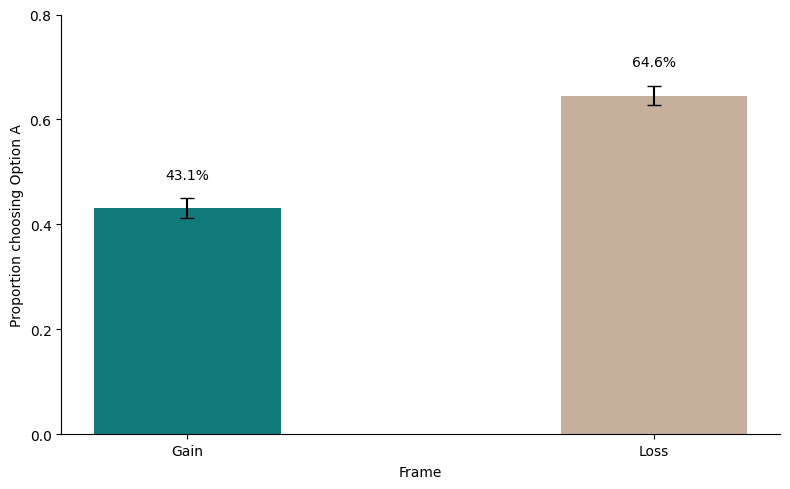

In [469]:
##GraphProportion Choosing Option A by Frame 
t7.frame = t7.frame.replace('gain', 'Gain')
t7.frame = t7.frame.replace('loss', 'Loss')


agg_data = t7.groupby('frame').option_selected.agg(
    prop_A_mean = lambda x: np.mean(x == "Proposal A"),
    prop_A_std = lambda x: np.std(x == "Proposal A") / np.sqrt(len(x))
).reset_index()
agg_data['conf_int'] = 1.96 * agg_data['prop_A_std']

plt.figure(figsize=(8, 5))

palette = {'Gain': '#008B8B', 'Loss': '#CDAF95'}

bars = sns.barplot(data=agg_data, x='frame', y='prop_A_mean', palette=palette, width = .4 ) ##, capsize=0.05) ##, width = 0.4)
bars.set_xticklabels(labels = ['Gain', 'Loss' ], rotation = 0, fontsize=10)
for i, bar in enumerate(bars.patches):
    yval = bar.get_height()
    yerr = agg_data['conf_int'].iloc[i]
    bars.text(bar.get_x() + bar.get_width() / 2, yval + 0.05,
              '{:.1%}'.format(yval), ha='center', va='bottom') 
    bars.errorbar(x=bar.get_x() + bar.get_width() / 2, y=yval,
                 yerr=yerr, color='black', capsize=5, fmt='none', elinewidth=1.5)

sns.despine()
plt.ylabel('Proportion choosing Option A', fontsize = 10)
plt.xlabel('Frame', labelpad = 5, fontsize = 10)
bars.set_yticks([0,.2,.4,.6,.8])
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()
fig = bars.get_figure()
fig.savefig("/Users/annaking/Documents/Github/riskychoiceframing_AI/Experiment 2/figures/propA_frame.png")


In [523]:
agg_data = t7.groupby(['scenario', 'frame']).option_selected.agg(
    prop_A_mean = lambda x: np.mean(x == "Proposal A"),
    prop_A_std = lambda x: np.std(x == "Proposal A") / np.sqrt(len(x))
).reset_index()

agg_data

,scenario,frame,prop_A_mean,prop_A_std
0,forest,Gain,0.398571,0.018505
1,forest,Loss,0.376786,0.020477
2,animal,Gain,0.227941,0.016087
3,animal,Loss,0.770270,0.015464
4,human,Gain,0.723333,0.018263
5,human,Loss,0.756757,0.015772


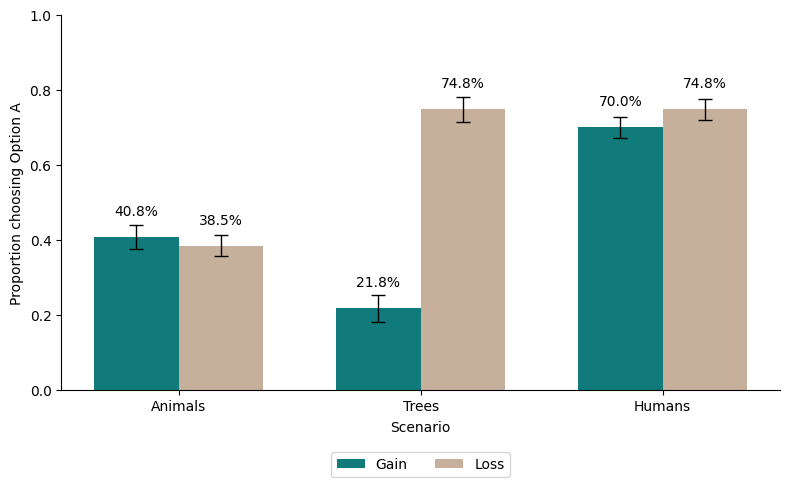

In [470]:
##GraphProportion Choosing Option A by Scenario 

agg_data = t7.groupby(['scenario', 'frame']).option_selected.agg(
    prop_A_mean = lambda x: np.mean(x == "Proposal A"),
    prop_A_std = lambda x: np.std(x == "Proposal A") / np.sqrt(len(x))
).reset_index()

agg_data['conf_int'] = 1.96 * agg_data['prop_A_std']

#order of bars
order = ['animals', 'forest', 'humans']
agg_data['scenario_clean'] = pd.Categorical(agg_data['scenario'], categories=order, ordered=True)
agg_data = agg_data.sort_values('scenario')

plt.figure(figsize=(8, 5))
palette = {'Gain': '#008B8B', 'Loss': '#CDAF95'}
bars = sns.barplot(data=agg_data, x='scenario', y='prop_A_mean', hue='frame', palette=palette, width = .7 ) 
bars.set_xticklabels(labels = ['Animals', 'Trees', 'Humans' ], rotation = 0, fontsize=10)
for i, bar in enumerate(bars.patches):
    yval = bar.get_height()
    yerr = agg_data['conf_int'].iloc[i]
    bars.text(bar.get_x() + bar.get_width() / 2, yval + 0.05,
              '{:.1%}'.format(yval), ha='center', va='bottom', fontsize=10) 
    bars.errorbar(x=bar.get_x() + bar.get_width() / 2, y=yval,
                 yerr=yerr, color='black', capsize=5, fmt='none', elinewidth=1)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        patch.set_width(new_value)
        patch.set_x(patch.get_x() + diff * .5)

change_width(bars, .35)
sns.despine()
plt.ylabel('Proportion choosing Option A', fontsize = 10)
plt.xlabel('Scenario', labelpad = 5, fontsize = 10)
bars.set_yticks([0,.2,.4,.6,.8,1])
plt.yticks(fontsize=10)
plt.legend( loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=2, fontsize=10)
plt.tight_layout()
plt.show()
fig = bars.get_figure()
fig.savefig("/Users/annaking/Documents/Github/riskychoiceframing_AI/Experiment 2/figures/propA_scn_frame.png")


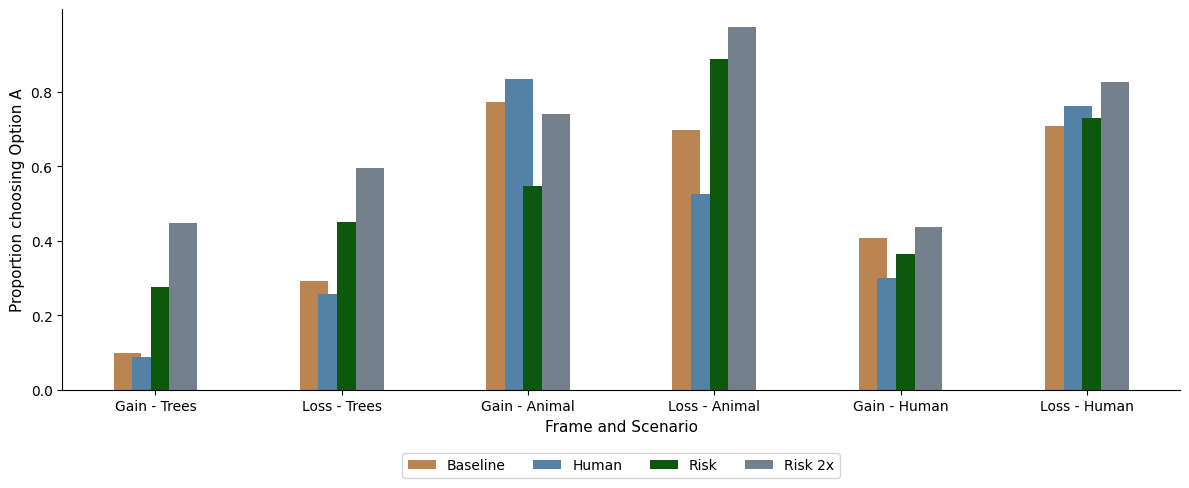

In [487]:
##Graph Proportion Choosing Option A by Test -- Frame Scenario

#df_round1 = df_round1.sort_values('test')
palette = ['peru', 'steelblue', 'darkgreen', 'slategray']
#tests = list(t1.test.unique())
#combo_names = [item.split(",")[0].strip("[]' ") for item in tests]
agg_data = t7.groupby(['combo', 'frame', 'scenario']).option_selected.agg(
    prop_A_mean = lambda x: np.mean(x == "Proposal A"),
    prop_A_std = lambda x: np.std(x == "Proposal A") / np.sqrt(len(x))
).reset_index()

#agg_data['frame'] = agg_data['frame'].astype('str')
agg_data['scenario'] = agg_data['scenario'].astype('str')

agg_data['conf_int'] = 1.96 * agg_data['prop_A_std']

agg_data['frame_scn'] = agg_data['frame'] + " - " + agg_data['scenario']

#order_test_scenario = agg_data['frame_scn'].unique()
#order = ['Gain - forest', 'Loss - forest','Gain - animal', 'Loss - animal', 'Gain - human', 'Loss - human']
#agg_data['frame_scn'] = pd.Categorical(agg_data['frame_scn'], categories=order, ordered=True)


plt.figure(figsize=(12, 5))
#palette = {'gain': '#008B8B', 'loss': '#C1CDCD'}

bars = sns.barplot(data=agg_data, x='frame_scn', y='prop_A_mean', hue='combo', palette = palette , width = .4 ) ##, capsize=0.05) ##, width = 0.4)
#bars.set_xticklabels(labels = combo_names, rotation = 0)
bars.set_yticks([0,.2,.4,.6,.8,])

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        patch.set_width(new_value)
        patch.set_x(patch.get_x() + diff * .5)

change_width(bars, .15)
sns.despine()
plt.ylabel('Proportion choosing Option A', fontsize = 11)
plt.xlabel('Frame and Scenario', fontsize = 11)
bars.set_xticklabels(['Gain - Trees', 'Loss - Trees','Gain - Animal', 'Loss - Animal', 'Gain - Human', 'Loss - Human'])

##plt.xlabel('Scenario', labelpad = 5)
##plt.legend( loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=2)
plt.legend( loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=4, fontsize=10)
plt.tight_layout()
plt.savefig("/Users/annaking/Documents/Github/riskychoiceframing_AI/Experiment 2/figures/PropA_test_frame_scn.png")
plt.show()

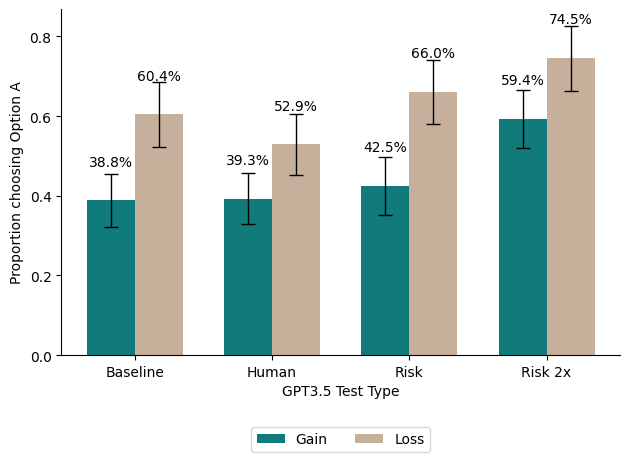

<Figure size 640x480 with 0 Axes>

In [505]:
##Graph Proportion Choosing Option A by Test

agg_data = t7.groupby(['scenario', 'frame', 'combo']).option_selected.agg(
    prop_A_mean = lambda x: np.mean(x == "Proposal A"),
    prop_A_std = lambda x: np.std(x == "Proposal A") / np.sqrt(len(x))
).reset_index()

agg_data['conf_int'] = 1.96 * agg_data['prop_A_std']

#order of bars
order = ['animals', 'forest', 'humans']
agg_data['scenario_clean'] = pd.Categorical(agg_data['scenario'], categories=order, ordered=True)
agg_data = agg_data.sort_values('scenario')
palette = {'Gain': '#008B8B', 'Loss': '#CDAF95'}

bars = sns.barplot(data=agg_data, x='combo', y='prop_A_mean', hue='frame', palette=palette, width = .7, errorbar=None ) ##, capsize=0.05) ##, width = 0.4)
bars.set_yticks([0,.2,.4,.6,.8,])
for i, bar in enumerate(bars.patches):
    yval = bar.get_height()
    yerr = agg_data['conf_int'].iloc[i]
    bars.text(bar.get_x() + bar.get_width() / 2, yval + 0.08,
              '{:.1%}'.format(yval), ha='center', va='bottom', fontsize=10) 
    bars.errorbar(x=bar.get_x() + bar.get_width() / 2, y=yval,
                 yerr=yerr, color='black', capsize=5, fmt='none', elinewidth=1)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        patch.set_width(new_value)
        patch.set_x(patch.get_x() + diff * .5)

change_width(bars, .35)
sns.despine()
plt.ylabel('Proportion choosing Option A')
plt.xlabel('GPT3.5 Test Type')
##plt.xlabel('Scenario', labelpad = 5)
plt.legend( loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=2, fontsize=10)
plt.tight_layout()
plt.show()

plt.savefig("/Users/annaking/Documents/Github/riskychoiceframing_AI/Experiment 2/figures/PropA_test__testtype_2.png")


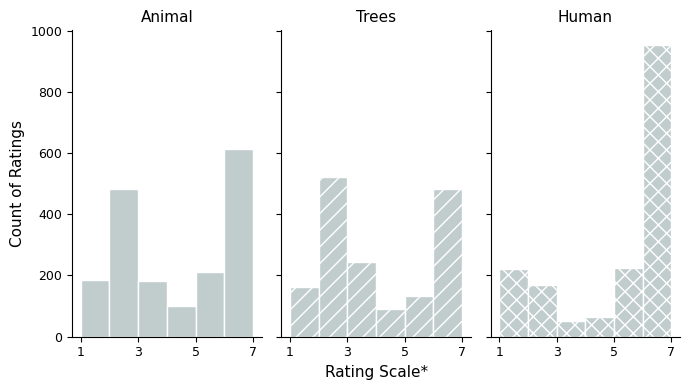

In [495]:
##Histogram Of Reversed Rating Num, Scenario & Frame (All)

loss_for = df_forest[df_forest['frame'] == 'loss']
loss_an = df_animal[df_animal['frame'] == 'loss']
loss_hum = df_human[df_human['frame'] == 'loss']

gain_for = df_forest[df_forest['frame'] == 'gain']
gain_an = df_animal[df_animal['frame'] == 'gain']
gain_hum = df_human[df_human['frame'] == 'gain']

colors = ['#C1CDCD']
fig, axes = plt.subplots(1, 3, figsize=(7, 4), sharey=True)

datasets = [df_animal, df_forest, df_human]
hatches = [None, '//', 'xx']  #
# plot bars
for i, data in enumerate(datasets):
    plot = sns.histplot(data=data, x='reversed_rating_num', ax=axes[i], color='#C1CDCD', edgecolor="w", alpha=1, binwidth=1) 
    axes[i].set_xticks([1,3,5,7])
    axes[i].tick_params(axis='both', labelsize=9)
    axes[i].set_ylabel("Count of Ratings", fontsize=11)
    if i == 1:
        axes[i].set_xlabel("Rating Scale*", fontsize=11)
    else: 
        axes[i].set_xlabel("")
    if i == 0:
        axes[i].set_title("Animal", fontsize=11)
    elif i == 1: 
        axes[i].set_title("Trees", fontsize=11)
    else:
        axes[i].set_title("Human", fontsize=11)
    #axes[i].set_yticks([0,5,10,15,20])

    # Apply hatch if it's not None
    if hatches[i] is not None:
        for bar in axes[i].patches:
            bar.set_hatch(hatches[i])
plt.tight_layout()
sns.despine()
plt.show()
fig = plot.get_figure()
fig.savefig("/Users/annaking/Documents/Github/riskychoiceframing_AI/Experiment 2/figures/raiting_scn_All.png")



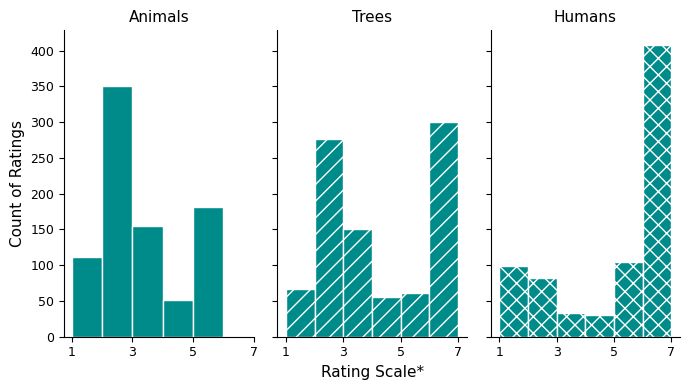

In [496]:
##Histogram Of Reversed Rating Num, Scenario & Frame (Gain)
fig, axes = plt.subplots(1, 3, figsize=(7, 4), sharey=True)

datasets = [gain_an, gain_for, gain_hum]
hatches = [None, '//', 'xx']  # None for animal, '//' for forest, and 'xx' for human

# plot bars
for i, data in enumerate(datasets):
    plot = sns.histplot(data=data, x='reversed_rating_num', ax=axes[i], color='#008B8B', edgecolor="w", alpha=1, binwidth=1) 
    axes[i].set_xticks([1,3,5,7])
    axes[i].tick_params(axis='both', labelsize=9)
    axes[i].set_ylabel("Count of Ratings", fontsize=11)
    if i == 1:
        axes[i].set_xlabel("Rating Scale*", fontsize=11)
    else: 
        axes[i].set_xlabel("")
    if i == 0:
        axes[i].set_title("Animals", fontsize=11)
    elif i == 1: 
        axes[i].set_title("Trees", fontsize=11)
    else:
        axes[i].set_title("Humans", fontsize=11)
   # axes[i].set_yticks([0,5,10,15,20])

    # Apply hatch if it's not None
    if hatches[i] is not None:
        for bar in axes[i].patches:
            bar.set_hatch(hatches[i])
plt.tight_layout()
sns.despine()
plt.show()
fig = plot.get_figure()
fig.savefig("/Users/annaking/Documents/Github/riskychoiceframing_AI/Experiment 2/figures/raiting_scn_gain.png")


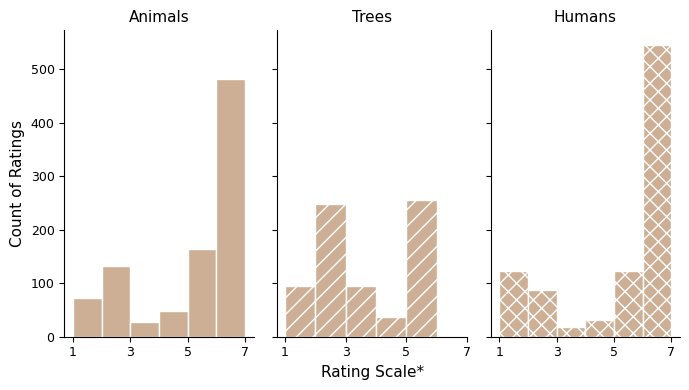

In [497]:
##Histogram Of Reversed Rating Num, Scenario & Frame (Loss)
fig, axes = plt.subplots(1, 3, figsize=(7, 4), sharey=True)

datasets = [loss_an, loss_for, loss_hum]
hatches = [None, '//', 'xx']  # None for animal, '//' for forest, and 'xx' for human

# plot bars
for i, data in enumerate(datasets):
    plot = sns.histplot(data=data, x='reversed_rating_num', ax=axes[i], color='#CDAF95', edgecolor="w", alpha=1, binwidth=1) 
    axes[i].set_xticks([1,3,5,7])
    axes[i].tick_params(axis='both', labelsize=9)
    axes[i].set_ylabel("Count of Ratings", fontsize=11)
    if i == 1:
        axes[i].set_xlabel("Rating Scale*", fontsize=11)
    else: 
        axes[i].set_xlabel("")
    if i == 0:
        axes[i].set_title("Animals", fontsize=11)
    elif i == 1: 
        axes[i].set_title("Trees", fontsize=11)
    else:
        axes[i].set_title("Humans", fontsize=11)
   # axes[i].set_yticks([0,5,10,15,20])

    if hatches[i] is not None:
        for bar in axes[i].patches:
            bar.set_hatch(hatches[i])
plt.tight_layout()
sns.despine()
plt.show()
fig = plot.get_figure()
fig.savefig("/Users/annaking/Documents/Github/riskychoiceframing_AI/Experiment 2/figures/raiting_scn_loss.png")


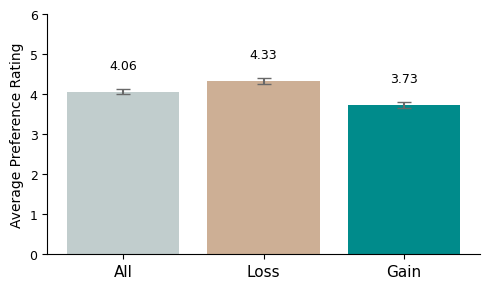

In [498]:
##Plot graph for average rating by condition 
values = np.array([t7.reversed_rating_num.mean(), loss_condition.reversed_rating_num.mean(), gain_condition.reversed_rating_num.mean(), ])
se = np.array([t7.reversed_rating_num.std(), loss_condition.reversed_rating_num.std(), gain_condition.reversed_rating_num.std()]) / np.sqrt([len(t7), len(loss_condition), len(gain_condition)])
yerrs = 1.96 * se

#plot
palette = ['#C1CDCD', '#CDAF95', '#008B8B']
plt.figure(figsize=(5, 3))
bars = plt.bar(np.arange(3), values, yerr=yerrs, color=palette, alpha=1, capsize=5, ecolor='dimgrey') 
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, '{:.2f}'.format(yval), ha='center', va='bottom', fontsize=9)

sns.despine()
plt.ylabel('Average Preference Rating', fontsize=10)
plt.yticks([0,1,2,3,4,5,6], fontsize=9)
plt.xticks(np.arange(3), ['All', 'Loss', 'Gain'], rotation='horizontal', fontsize=11)
plt.tick_params(axis='y', labelsize=9)
plt.tight_layout()
plt.show()
fig.savefig("/Users/annaking/Documents/Github/riskychoiceframing_AI/Experiment 2/figures/avgratingbycondition.png")



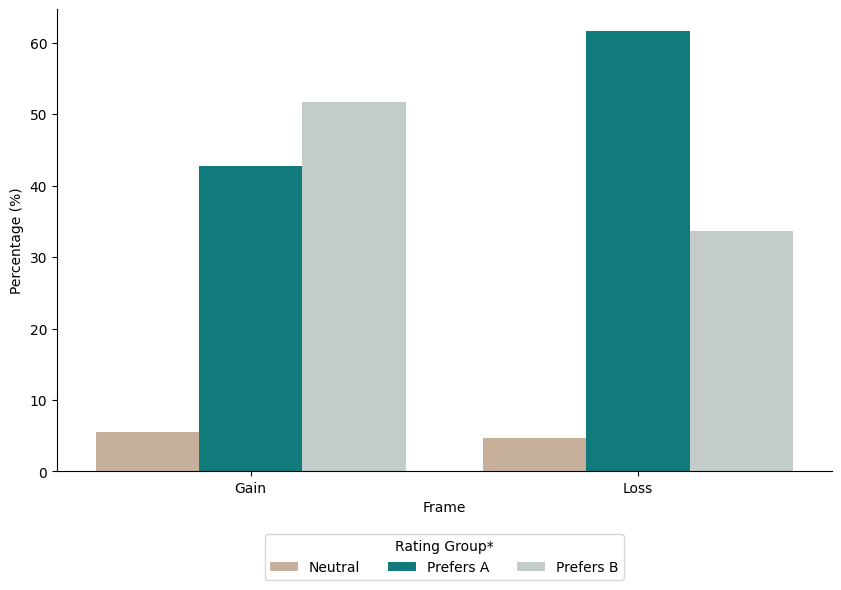

In [499]:
## Bar Graph of Rating Num by Grouping & Frame
pd.crosstab( index = t7['reversed_rating_num'], columns = t7['frame'], margins = True)
rat_group_dict = {'pref A': [5,6,7], 'pref B': [1,2,3], 'Neut': [4]}

t7['reversed_rating_group'] = t7['reversed_rating_num'].apply(
    lambda x: 'Prefers A' if x in rat_group_dict['pref A'] else ('Prefers B' if x in rat_group_dict['pref B'] else 'Neutral')
)

dat = pd.crosstab(
    index=t7['reversed_rating_group'], 
    columns=t7['frame'], 
    margins=True, 
    normalize='columns'
).multiply(100).round(2).reset_index()  # Convert proportions to percentages

dat_melted = dat.melt(id_vars='reversed_rating_group', value_vars=['Gain', 'Loss'])  # Excluding 'All' since it's a summary

palette = [ '#CDAF95', '#008B8B', '#C1CDCD',]
plt.figure(figsize=(10, 6))

# Set 'frame' as x-axis and group by 'reversed_rating_group' using hue
sns.barplot(x='frame', y='value', hue='reversed_rating_group', data=dat_melted, palette=palette)
plt.ylabel('Percentage (%)')
plt.xlabel('Frame')  
plt.legend() 
sns.despine()
plt.legend( title='Rating Group*', loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=3, fontsize=10)
plt.show()
fig.savefig("/Users/annaking/Documents/Github/riskychoiceframing_AI/Experiment 2/figures/rating_groups.png")



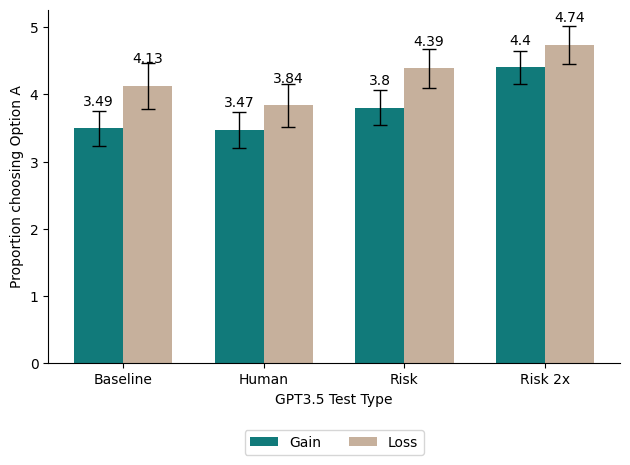

In [500]:
##Rating Num by Test Type

agg_data = t7.groupby(['scenario', 'frame', 'combo']).reversed_rating_num.agg(
    rating_num_mean = lambda x: np.mean(x),
   rating_num_std = lambda x: np.std(x) / np.sqrt(len(x))
).reset_index()

agg_data['conf_int'] = 1.96 * agg_data['rating_num_std']

#order of bars
order = ['animals', 'forest', 'humans']
agg_data['scenario_clean'] = pd.Categorical(agg_data['scenario'], categories=order, ordered=True)
agg_data = agg_data.sort_values('scenario')
palette = {'Gain': '#008B8B', 'Loss': '#CDAF95'}

bars = sns.barplot(data=agg_data, x='combo', y='rating_num_mean', hue='frame', palette=palette, width = .7, errorbar=None ) ##, capsize=0.05) ##, width = 0.4)
#bars.set_yticks([0,.2,.4,.6,.8,])
for i, bar in enumerate(bars.patches):
    yval = bar.get_height()
    yerr = agg_data['conf_int'].iloc[i]
    bars.text(bar.get_x() + bar.get_width() / 2, yval + 0.3,
              round(yval,2), ha='center', va='bottom', fontsize=10) 
    bars.errorbar(x=bar.get_x() + bar.get_width() / 2, y=yval,
                 yerr=yerr, color='black', capsize=5, fmt='none', elinewidth=1)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        patch.set_width(new_value)
        patch.set_x(patch.get_x() + diff * .5)

change_width(bars, .35)
sns.despine()
plt.ylabel('Proportion choosing Option A')
plt.xlabel('GPT3.5 Test Type')
##plt.xlabel('Scenario', labelpad = 5)
plt.legend( loc='lower center', bbox_to_anchor=(0.5, -0.28), ncol=2, fontsize=10)
plt.tight_layout()
plt.show()
fig.savefig("/Users/annaking/Documents/Github/riskychoiceframing_AI/Experiment 2/figures/rating_num_testtype.png")


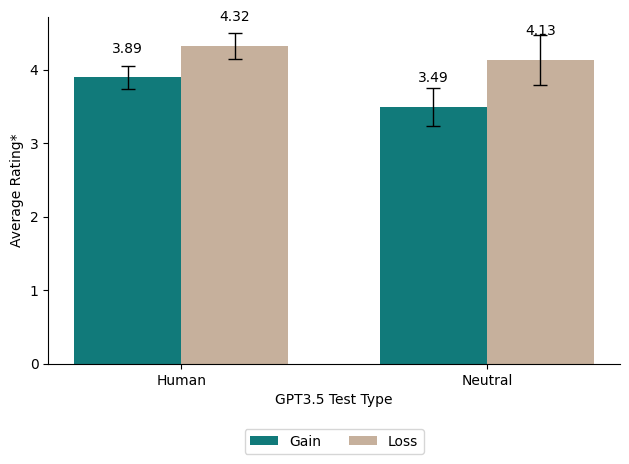

In [501]:
##Rating Num by Sys Role
t7.frame = t7.frame.replace('gain', 'Gain')
t7.frame = t7.frame.replace('loss', 'Loss')
t7.sys_role = t7.sys_role.replace('neutral_system', 'Neutral')
t7.sys_role = t7.sys_role.replace('human', 'Human')

agg_data = t7.groupby(['scenario', 'frame', 'sys_role']).reversed_rating_num.agg(
    rating_num_mean = lambda x: np.mean(x),
   rating_num_std = lambda x: np.std(x) / np.sqrt(len(x))
).reset_index()

agg_data['conf_int'] = 1.96 * agg_data['rating_num_std']

#order of bars
order = ['animals', 'forest', 'humans']
agg_data['scenario_clean'] = pd.Categorical(agg_data['scenario'], categories=order, ordered=True)
agg_data = agg_data.sort_values('scenario')
palette = {'Gain': '#008B8B', 'Loss': '#CDAF95'}

bars = sns.barplot(data=agg_data, x='sys_role', y='rating_num_mean', hue='frame', palette=palette, width = .7, errorbar=None ) ##, capsize=0.05) ##, width = 0.4)
bars.set_yticks([0,1,2,3,4,5,6,7])
for i, bar in enumerate(bars.patches):
    yval = bar.get_height()
    yerr = agg_data['conf_int'].iloc[i]
    bars.text(bar.get_x() + bar.get_width() / 2, yval + 0.3,
              round(yval,2), ha='center', va='bottom', fontsize=10) 
    bars.errorbar(x=bar.get_x() + bar.get_width() / 2, y=yval,
                 yerr=yerr, color='black', capsize=5, fmt='none', elinewidth=1)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        patch.set_width(new_value)
        patch.set_x(patch.get_x() + diff * .5)

change_width(bars, .35)
sns.despine()
plt.ylabel('Average Rating*')
plt.xlabel('GPT3.5 Test Type')
##plt.xlabel('Scenario', labelpad = 5)
plt.legend( loc='lower center', bbox_to_anchor=(0.5, -0.28), ncol=2, fontsize=10)
plt.tight_layout()
plt.show()
fig.savefig("/Users/annaking/Documents/Github/riskychoiceframing_AI/Experiment 2/figures/rating_num_sysrole.png")


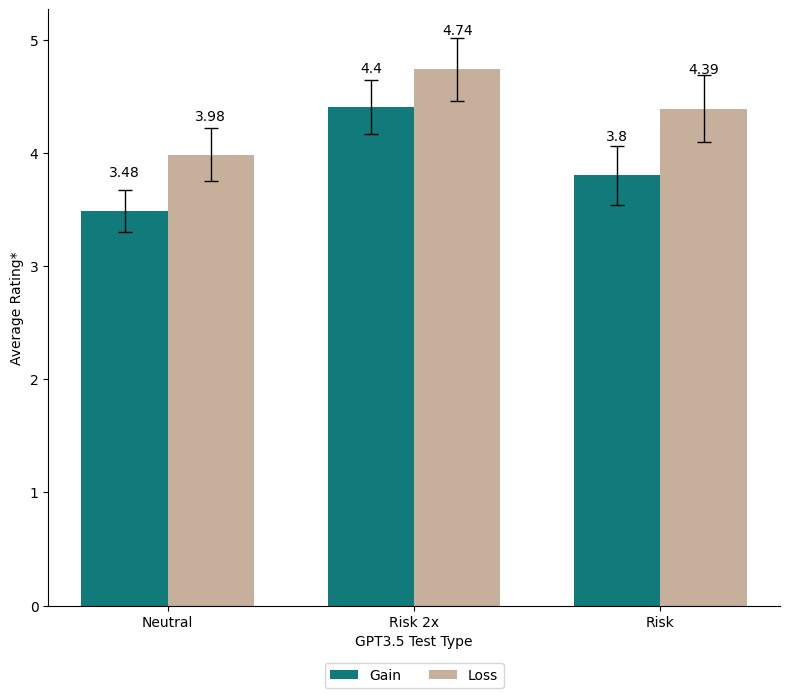

In [502]:
##Rating Num by Risk
t7.frame = t7.frame.replace('gain', 'Gain')
t7.frame = t7.frame.replace('loss', 'Loss')
t7.risk = t7.risk.replace('neutral_risk', 'Neutral')
t7.risk = t7.risk.replace('risk', 'Risk')
t7.risk = t7.risk.replace('risk_humrisk', 'Risk 2x')

plt.figure(figsize=(8, 7))

agg_data = t7.groupby(['scenario', 'frame', 'risk']).reversed_rating_num.agg(
    rating_num_mean = lambda x: np.mean(x),
   rating_num_std = lambda x: np.std(x) / np.sqrt(len(x))
).reset_index()

agg_data['conf_int'] = 1.96 * agg_data['rating_num_std']

#order of bars
order = ['animals', 'forest', 'humans']
agg_data['scenario_clean'] = pd.Categorical(agg_data['scenario'], categories=order, ordered=True)
agg_data = agg_data.sort_values('scenario')
palette = {'Gain': '#008B8B', 'Loss': '#CDAF95'}

bars = sns.barplot(data=agg_data, x='risk', y='rating_num_mean', hue='frame', palette=palette, width = .7, errorbar=None ) ##, capsize=0.05) ##, width = 0.4)
bars.set_yticks([0, 1,2,3,4,5,6,7])
for i, bar in enumerate(bars.patches):
    yval = bar.get_height()
    yerr = agg_data['conf_int'].iloc[i]
    bars.text(bar.get_x() + bar.get_width() / 2, yval + 0.28,
              round(yval,2), ha='center', va='bottom', fontsize=10) 
    bars.errorbar(x=bar.get_x() + bar.get_width() / 2, y=yval,
                 yerr=yerr, color='black', capsize=5, fmt='none', elinewidth=1)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        patch.set_width(new_value)
        patch.set_x(patch.get_x() + diff * .5)

change_width(bars, .35)
sns.despine()
plt.ylabel('Average Rating*')
plt.xlabel('GPT3.5 Test Type')
##plt.xlabel('Scenario', labelpad = 5)
plt.legend( loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=10)
plt.tight_layout()
plt.show()
fig.savefig("/Users/annaking/Documents/Github/riskychoiceframing_AI/Experiment 2/figures/rating_num_risk.png")


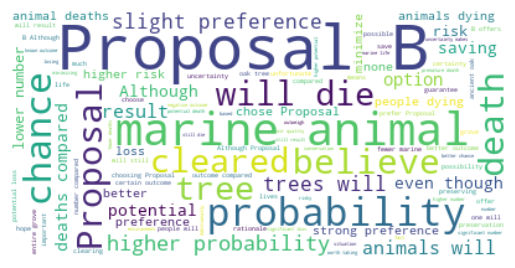

In [260]:
##Graph Proportion Choosing Option A by Test

agg_data = t7.groupby(['scenario', 'frame', 'combo']).option_selected.agg(
    prop_A_mean = lambda x: np.mean(x == "Proposal A"),
    prop_A_std = lambda x: np.std(x == "Proposal A") / np.sqrt(len(x))
).reset_index()

agg_data['conf_int'] = 1.96 * agg_data['prop_A_std']

#order of bars
order = ['animals', 'forest', 'humans']
agg_data['scenario_clean'] = pd.Categorical(agg_data['scenario'], categories=order, ordered=True)
agg_data = agg_data.sort_values('scenario')
palette = {'Gain': '#008B8B', 'Loss': '#CDAF95'}

bars = sns.barplot(data=agg_data, x='combo', y='prop_A_mean', hue='frame', palette=palette, width = .7, errorbar=None ) ##, capsize=0.05) ##, width = 0.4)
bars.set_yticks([0,.2,.4,.6,.8,])
for i, bar in enumerate(bars.patches):
    yval = bar.get_height()
    yerr = agg_data['conf_int'].iloc[i]
    bars.text(bar.get_x() + bar.get_width() / 2, yval + 0.08,
              '{:.1%}'.format(yval), ha='center', va='bottom', fontsize=10) 
    bars.errorbar(x=bar.get_x() + bar.get_width() / 2, y=yval,
                 yerr=yerr, color='black', capsize=5, fmt='none', elinewidth=1)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        patch.set_width(new_value)
        patch.set_x(patch.get_x() + diff * .5)

change_width(bars, .35)
sns.despine()
plt.ylabel('Proportion choosing Option A')
plt.xlabel('GPT3.5 Test Type')
##plt.xlabel('Scenario', labelpad = 5)
plt.legend( loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=2, fontsize=10)
plt.tight_layout()
plt.show()
fig.savefig("/Users/annaking/Documents/Github/riskychoiceframing_AI/Experiment 1/figures/PropA_test_exp2_testtype.png")


#### Stat Tests for Hypotheses

In [509]:
###H1: Chi-squared Test (or Fisher's Exact Test) for Option Selected:
contingency_table = pd.crosstab(t7['frame'], t7['option_selected'])
chi2, pval, _, _ = stats.chi2_contingency(contingency_table)

contingency_table2 = pd.crosstab(round1_df['frame'], round1_df['option_selected'])
chi2_2, pval_2, _, _ = stats.chi2_contingency(contingency_table2)

###Output as a table
results_h1 = {
    ('option selected_all'): {
        'chi2/stat': round(chi2,3),
        'p_val': round(pval,4),
        'sig effect': pval < .05
    },
    ('option selected_r1'): {
        'chi2/stat': round(chi2_2,3),
        'p_val': pval_2,
        'sig effect': pval_2 < .05
    }}

df_hyp_test = pd.DataFrame.from_dict(results_h1)
df_hyp_test

,option selected_all,option selected_r1
chi2/stat,193.73,32.471
p_val,0.0,0.0
sig effect,True,True


In [226]:
###H2: Kruskal-Wallis Test for Rating ##CHECK ##Reversed Number 
stat, p_val = stats.mannwhitneyu(t7[t7['frame']=='Gain']['reversed_rating_num'], t7[t7['frame']=='Loss']['reversed_rating_num'])
stat_2, p_val_2 = stats.mannwhitneyu(round1_df[round1_df['frame']=='Gain']['reversed_rating_num'], round1_df[round1_df['frame']=='Loss']['reversed_rating_num'])

###Output as a table
resultsh2 = {
   
    ('rating number_all'): {
        'chi2/stat': stat,
        'p_val': p_val,
        'sig effect': p_val < .05
    },
    ('rating number_r1'): {
        'chi2/stat': stat_2,
        'p_val': p_val_2,
        'sig effect': p_val_2 < .05
    }
    
    }

df_hyp_test = pd.DataFrame.from_dict(resultsh2)
df_hyp_test.to_csv('df_hyp2_test_exp2.csv')
df_hyp_test

,rating number_all,rating number_r1
chi2/stat,3435234.5,68201.5
p_val,0.0,0.000065
sig effect,True,True
